In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions, VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

In [2]:
! pip install kaggle
! mkdir ~/.kaggle 

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets download -d sumansid/facemask-dataset

! unzip facemask-dataset.zip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 87% 100M/114M [00:00<00:00, 158MB/s] 
100% 114M/114M [00:00<00:00, 159MB/s]
Archive:  facemask-dataset.zip
  inflating: Mask/Mask/Mask109.jpg   
  inflating: Mask/Mask/Mask11.jpg    
  inflating: Mask/Mask/Mask110.jpeg  
  inflating: Mask/Mask/Mask111.jpeg  
  inflating: Mask/Mask/Mask112.jpeg  
  inflating: Mask/Mask/Mask113.jpeg  
  inflating: Mask/Mask/Mask114.jpeg  
  inflating: Mask/Mask/Mask115.jpeg  
  inflating: Mask/Mask/Mask116.jpeg  
  inflating: Mask/Mask/Mask117.jpeg  
  inflating: Mask/Mask/Mask118.jpeg  
  inflating: Mask/Mask/Mask119.jpeg  
  inflating: Mask/Mask/Mask120.jpeg  
  inflating: Mask/Mask/Mask121.jpeg  
  inflating: Mask/Mask/Mask122.jpeg  
  inflating: Mask/Mask/Mask123.jpeg  
  inflating: Mask/Mask/Mask124.jpg   
  inflating: Mask/Mask/Mask125.jpg   
  inflating: Mask/Mask/Mask126.jpg   
  inflating: Mask/Mask/Mask13.jpg    
  inflating: Mask/Mask/Mask130.jp

In [5]:
import os
def ClassFreq(ROOT_DIR):
  number_of_images = {}

  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

  print(number_of_images.items())



ClassFreq("/content/original")

dict_items([('No Mask', 131), ('Mask', 208)])


In [11]:
import shutil
ROOT_DIR = "/content/original"

number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
print(number_of_images.items())




def dataFolder(path, split):
  
  if not os.path.exists("./"+path): 
    os.mkdir("./"+path)            

    for dir in os.listdir(ROOT_DIR): 
      os.makedirs("./"+path+"/"+dir)      
      
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split*number_of_images[dir])-5), replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+path, dir)
        shutil.copy(O,D)
        os.remove(O)
        
  else:
    print(f"{path} directory already exists")

  print(f"{path} directory has been created")

dict_items([('No Mask', 97), ('Mask', 151)])


In [12]:
import math
import glob
dataFolder("train",0.7)
dataFolder("test",0.3)


ClassFreq("/content/train")
ClassFreq("/content/test")

train directory has been created
test directory has been created
dict_items([('No Mask', 62), ('Mask', 100)])
dict_items([('No Mask', 24), ('Mask', 40)])


In [13]:
train_datasets = "Datasets/train/"
test_datasets = "Datasets/test/"

In [14]:
image_size = (150,150)
number_class = 2
batch_size = 10
number_epochs = 10
learningRate = 0.001

In [15]:
train_dataset_generator = ImageDataGenerator(rescale = 1./255, #range = [0, 1]
                                            rotation_range = 45,
                                            featurewise_center = True,
                                            featurewise_std_normalization = True,
                                            height_shift_range=0.2,
                                            width_shift_range=0.2,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            channel_shift_range = 20,
                                            horizontal_flip = True,
                                            vertical_flip = True,
                                            validation_split = 0.2, 
                                            fill_mode="constant")

In [16]:
train_batches = train_dataset_generator.flow_from_directory(train_datasets,
                                                           target_size= image_size,
                                                           shuffle=True,
                                                           batch_size=batch_size,
                                                           subset='training',
                                                           seed=42,
                                                           class_mode = "binary")

Found 130 images belonging to 2 classes.


In [17]:
validation_batches = train_dataset_generator.flow_from_directory(train_datasets,
                                                           target_size= image_size,
                                                           shuffle=True,
                                                           batch_size=batch_size,
                                                           subset='validation',
                                                           seed=42,
                                                           class_mode = "binary")

Found 32 images belonging to 2 classes.


In [18]:
vgg_model = VGG16(weights="imagenet",
                 include_top = False,
                 input_shape=(150, 150, 3))

vgg_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [20]:
model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(learning_rate = learningRate), 
             metrics = ['accuracy'])

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [22]:
print(len(train_batches))
print()
print(len(validation_batches))

13

4


In [23]:
print(train_batches.n)
print()
print(validation_batches.n)

130

32


In [24]:
print(train_batches.batch_size)
print()
print(validation_batches.batch_size)

10

10


In [25]:
train_step_size = train_batches.n // train_batches.batch_size
validation_step_size = validation_batches.n //validation_batches.batch_size

In [26]:
model_runing_history = model.fit(train_batches, 
                                steps_per_epoch = train_step_size,
                                validation_data=validation_batches,
                                validation_steps=validation_step_size,
                                epochs = number_epochs)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
 8/13 [=================>............] - ETA: 13s - loss: 1.0486 - accuracy: 0.6500

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


13/13 [==============================] - 45s 3s/step - loss: 0.8124 - accuracy: 0.6846 - val_loss: 0.6138 - val_accuracy: 0.6667
Epoch 2/10
13/13 [==============================] - 41s 3s/step - loss: 0.3310 - accuracy: 0.8615 - val_loss: 0.9973 - val_accuracy: 0.6000
Epoch 3/10
13/13 [==============================] - 40s 3s/step - loss: 0.2588 - accuracy: 0.8846 - val_loss: 0.3467 - val_accuracy: 0.7667
Epoch 4/10
13/13 [==============================] - 40s 3s/step - loss: 0.1996 - accuracy: 0.9077 - val_loss: 0.5213 - val_accuracy: 0.7333
Epoch 5/10
13/13 [==============================] - 40s 3s/step - loss: 0.2187 - accuracy: 0.9154 - val_loss: 0.4156 - val_accuracy: 0.7667
Epoch 6/10
13/13 [==============================] - 40s 3s/step - loss: 0.1652 - accuracy: 0.9077 - val_loss: 0.2069 - val_accuracy: 0.9333
Epoch 7/10
13/13 [==============================] - 40s 3s/step - loss: 0.2816 - accuracy: 0.8846 - val_loss: 0.2105 - val_accuracy: 0.8667
Epoch 8/10
13/13 [=============

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy_loss_plot(model_data, epochs):
    
    
    acc = model_runing_history.history['accuracy']
    loss = model_runing_history.history['loss']
    val_acc = model_runing_history.history['val_accuracy']
    val_loss = model_runing_history.history['val_loss']
    
    plt.figure(figsize = (20, 8))
    plt.subplot(121)
    plt.plot(range(1, epochs), acc[1:], label = 'Training Accuracy')
    plt.plot(range(1, epochs), val_acc[1:], label = 'Test Accuracy')
    plt.title("Accuracy Over " + str(epochs) + "Epochs", size = 15)
    plt.legend()
    plt.grid(True)
    
    
    
    plt.figure(figsize = (20, 8))
    plt.subplot(122)
    plt.plot(range(1, epochs), loss[1:], label = 'Training Loss')
    plt.plot(range(1, epochs), val_loss[1:], label = 'Test Loss')
    plt.title("Loss Over " + str(epochs) + "Epochs", size = 15)
    plt.legend()
    plt.grid(True)
    
    plt.show()

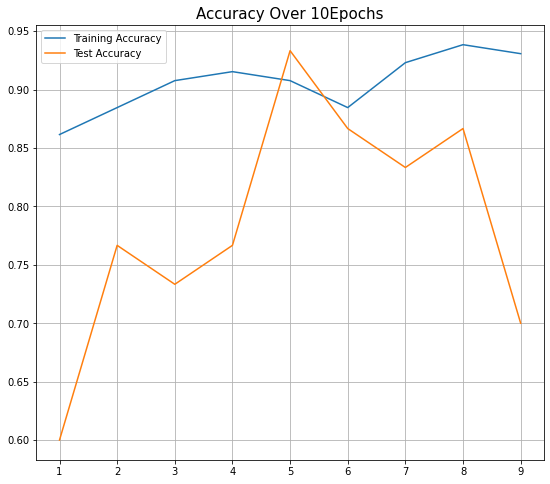

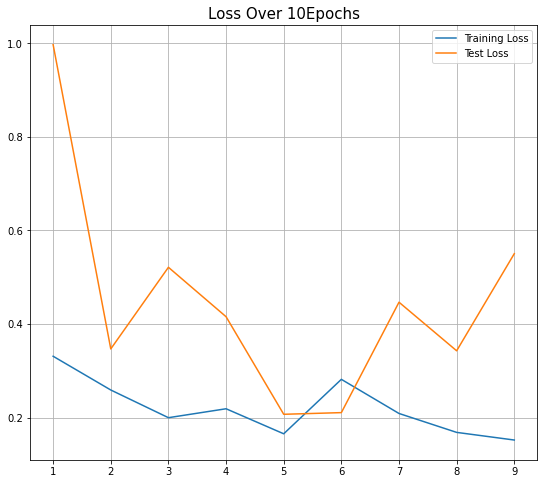

In [28]:
accuracy_loss_plot(model_runing_history, 10)

In [29]:
model.save("ClassificationModel.h5")

In [30]:
test_datagenrator = ImageDataGenerator(rescale=1./255)
test_batches = test_datagenrator.flow_from_directory(test_datasets,
                                       target_size= image_size,
                                       shuffle=False,
                                       batch_size=1,
                                       seed=42,
                                       class_mode = "binary")

test_batches.reset()

Found 64 images belonging to 2 classes.


In [31]:
test_batches.reset()
random_data = model.evaluate(test_batches,
                            steps = int(np.ceil(len(test_batches) / batch_size)), 
                             use_multiprocessing = False,
                            verbose = 1,
                             workers = 1)

7/7 [==============================] - 3s 401ms/step - loss: 0.0044 - accuracy: 1.0000


In [32]:
print("TestDatasets Loss: ", random_data[0])
print("TestDatasets Accuracy: ", random_data[1])

TestDatasets Loss:  0.004399830475449562
TestDatasets Accuracy:  1.0


In [33]:
test_batches.reset()
predictted = model.predict(test_batches, 1000, verbose=1)

64/64 [==============================] - 18s 271ms/step


Mask/Mask11.jpg


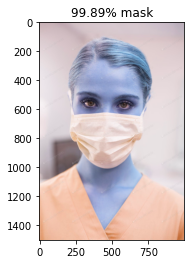

Mask/Mask110.jpeg


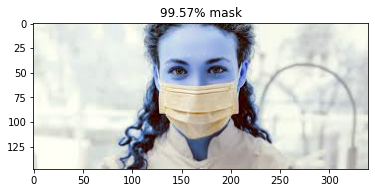

Mask/Mask117.jpeg


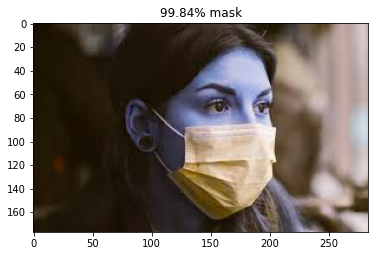

Mask/Mask122.jpeg


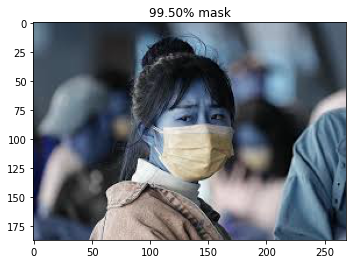

Mask/Mask138.jpg


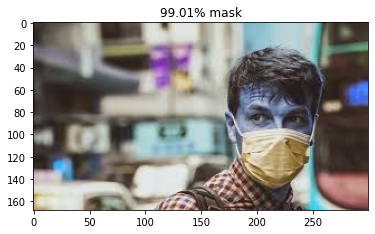

Mask/Mask147.jpg


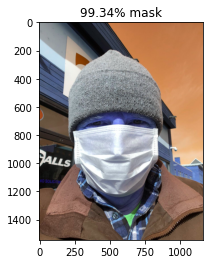

Mask/Mask163.png


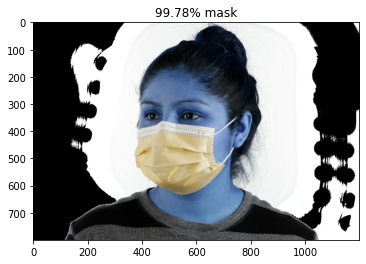

Mask/Mask164.jpg


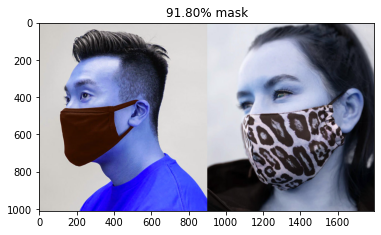

Mask/Mask165.jpg


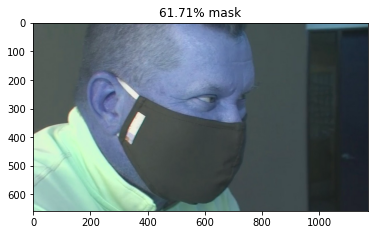

Mask/Mask169.jpg


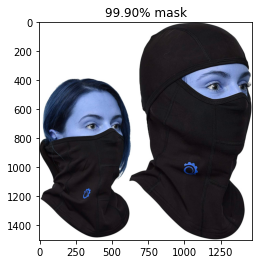

Mask/Mask181.jpg


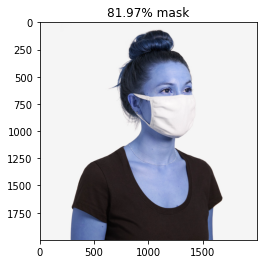

Mask/Mask199.jpg


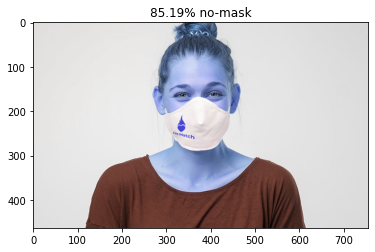

Mask/Mask200.jpg


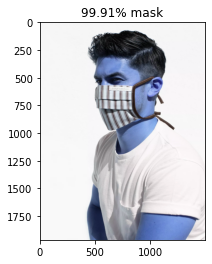

Mask/Mask202.jpg


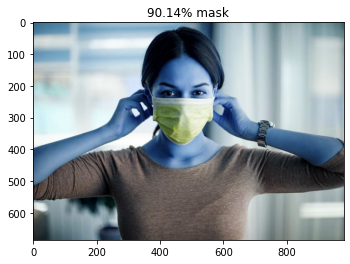

Mask/Mask214.jpeg


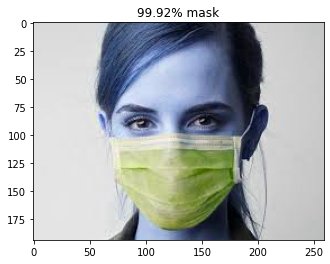

Mask/Mask224.jpeg


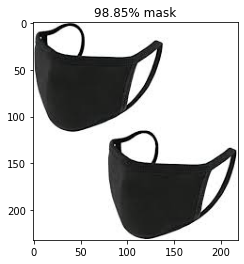

Mask/Mask227.jpeg


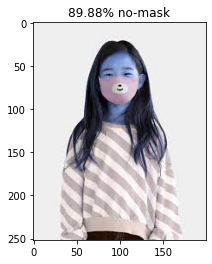

Mask/Mask228.jpg


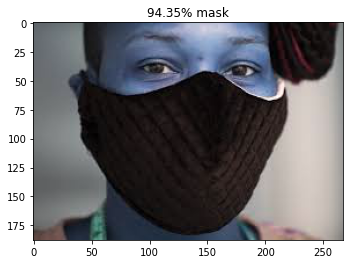

Mask/Mask229.jpg


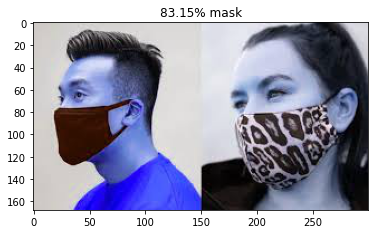

Mask/Mask231.jpg


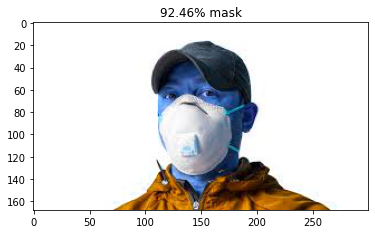

Mask/Mask242.jpg


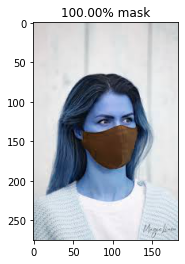

Mask/Mask244.jpg


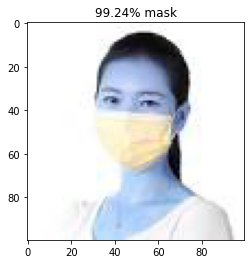

Mask/Mask249.jpg


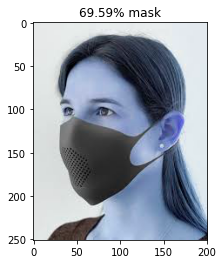

Mask/Mask261.jpg


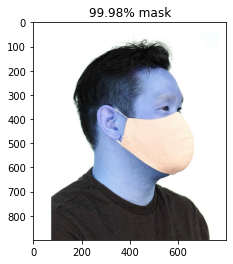

Mask/Mask262.jpg


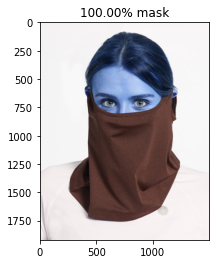

Mask/Mask269.jpg


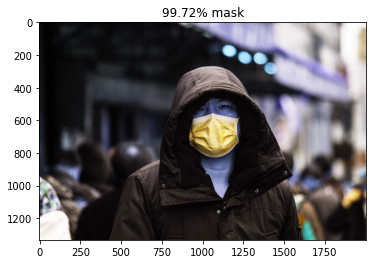

Mask/Mask271.jpg


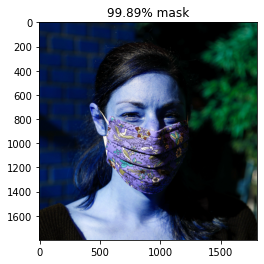

Mask/Mask273.jpg


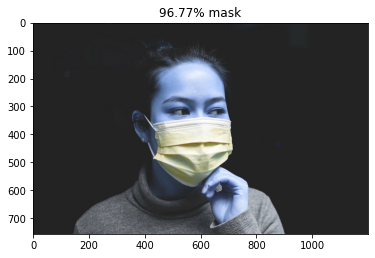

Mask/Mask278.jpg


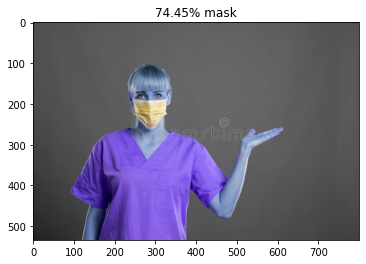

Mask/Mask280.jpg


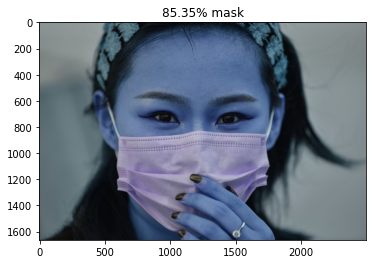

Mask/Mask282.jpg


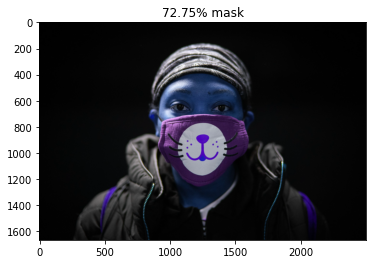

Mask/Mask285.jpg


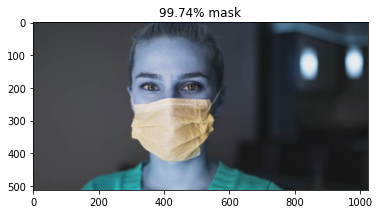

Mask/Mask286.jpg


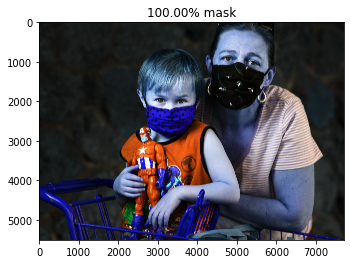

Mask/Mask30.jpg


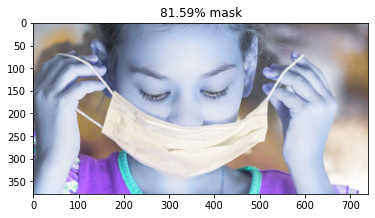

Mask/Mask46.jpg


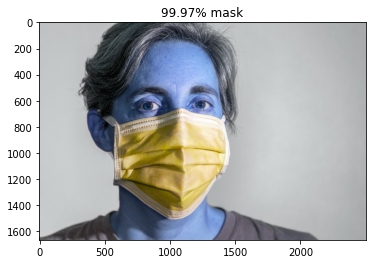

Mask/Mask5.jpg


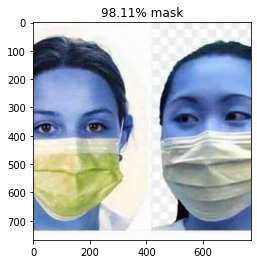

Mask/Mask62.jpg


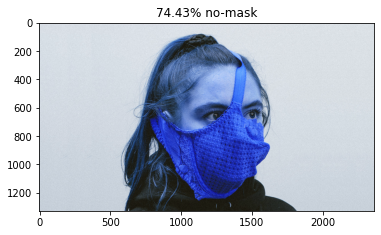

Mask/Mask73.jpeg


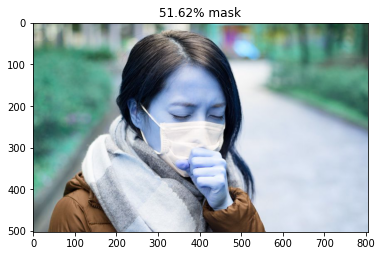

Mask/Mask80.jpg


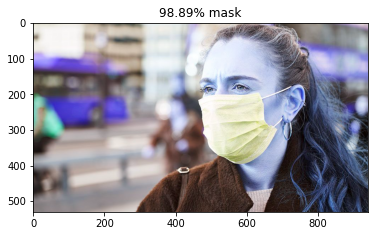

Mask/Mask89.jpeg


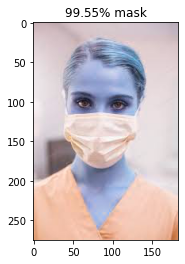

No Mask/No Mask103.jpg


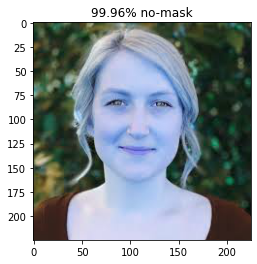

No Mask/No Mask115.jpg


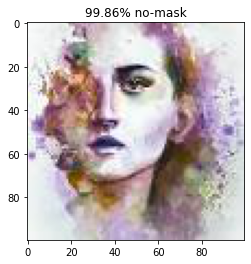

No Mask/No Mask121.jpg


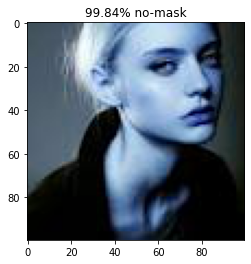

No Mask/No Mask13.jpg


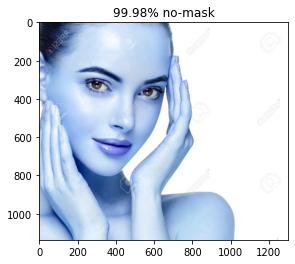

No Mask/No Mask14.jpg


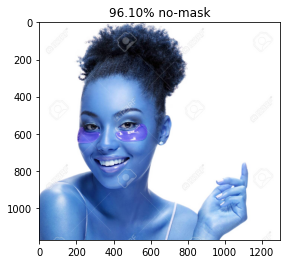

No Mask/No Mask15.jpg


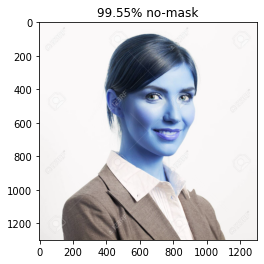

No Mask/No Mask18.jpg


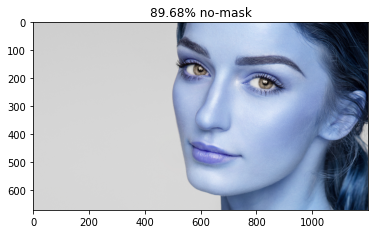

No Mask/No Mask19.jpg


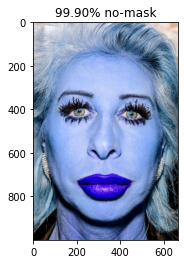

No Mask/No Mask21.jpg


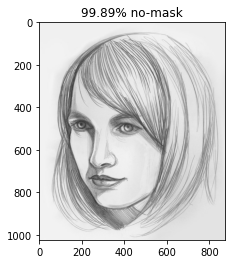

No Mask/No Mask22.jpg


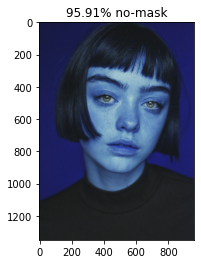

No Mask/No Mask23.jpg


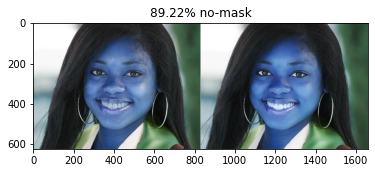

No Mask/No Mask26.jpg


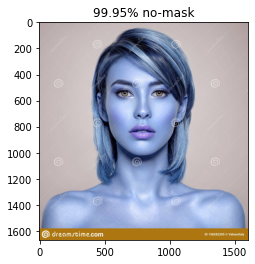

No Mask/No Mask28.jpg


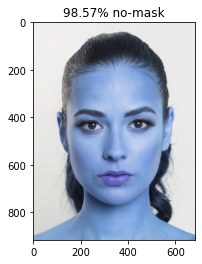

No Mask/No Mask29.jpg


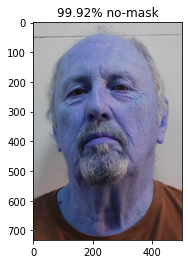

No Mask/No Mask40.jpg


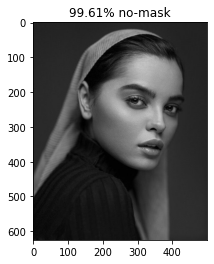

No Mask/No Mask51.jpg


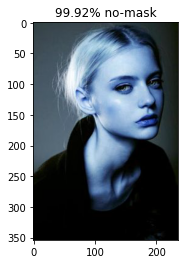

No Mask/No Mask60.jpg


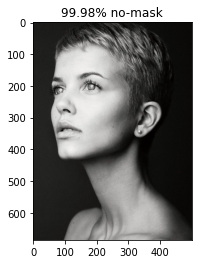

No Mask/No Mask63.jpeg


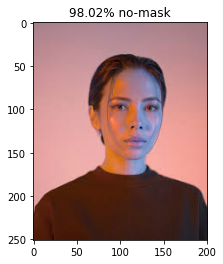

No Mask/No Mask68.jpeg


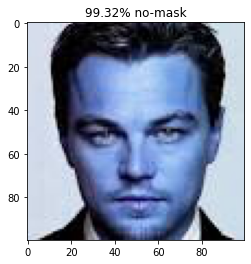

No Mask/No Mask74.jpeg


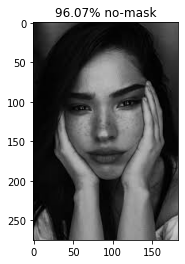

No Mask/No Mask78.jpeg


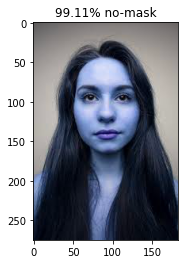

No Mask/No Mask90.jpg


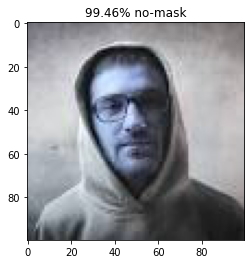

No Mask/No Mask92.jpg


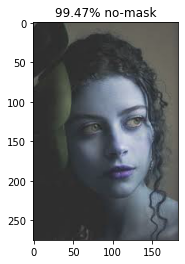

No Mask/No Mask95.jpg


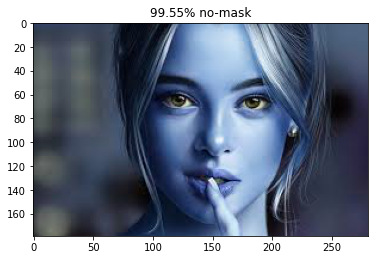

In [35]:
import cv2
import matplotlib.image as mat_image

for index, prob_value in enumerate(predictted):
    image_path = test_datasets + "/"+ test_batches.filenames[index]
    image = mat_image.imread(image_path)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pixel = np.array(image)
    plt.imshow(pixel)
    print(test_batches.filenames[index])
    
    if prob_value > 0.5:
        plt.title("%.2f" % (prob_value[0]*100) + "% no-mask")
    else:
        plt.title("%.2f" % ((1 - prob_value[0])*100) + "% mask")
        
    plt.show()